# Anti-Arab Hate Speech Detection System

## NLP Final Project — Spring 2025

### Authors
- Nicholas
- Clara
- Naif
- Alzmami

---

## Libraries

In [ ]:
# Data handling and parsing
import pandas as pd
from google.colab import files
import re

# NLP and text processing
import nltk
from nltk.corpus import stopwords
import spacy

# Machine Learning toolkits and BERT pretrained
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Analyzing and Visualizing Performance of Models
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer # Lightweight embedding model
from sklearn.linear_model import LogisticRegression # Effective baseline classifier
import matplotlib.pyplot as plt

## Preprocessing Tweet Data

In [ ]:
# Stopwords in memory
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


For convenience ensure the data file, titled "data.txt" is in an accessible directory to be easily uploaded to the Colab disk

In [ ]:
uploaded = files.upload()
hate_speech_file = list(uploaded.keys())[0] # Provided data file of tweets was used for training

# Expected number of fields, the data is of form: "index, annotator count, # hate speech, # offensive, # neither, class, tweet text"
EXPECTED_FIELDS = 7

Saving data.txt to data.txt


In [ ]:
def safe_load_csv(filepath):
    rows = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= EXPECTED_FIELDS: # Skip lines that are too short (permit lines that are too long)
                try:
                    index = int(parts[0])
                    hate = int(parts[2])
                    offensive = int(parts[3])
                    neither = int(parts[4])
                    text = ",".join(parts[6:])  # tweet text may contain commas
                    label = 1 if (hate + offensive) > neither else 0 # Calculate hate speech or not based on annotator consensus (majority)
                    rows.append((index, label, text))
                except ValueError:
                    continue  # Skip lines with bad numeric conversion
    return pd.DataFrame(rows, columns=["index", "label", "raw_text"]) # New CSV format

We transform the original dataset into the format "index", "label", "raw_text", because the label is necessary for having a "ground truth".  The label is derived from determining consensus across all annotators that partook in labelling the tweets dataset.  Effectively, majority decision / vote dictates whether a post is hate speech or not.

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)            # Remove URLs
    text = re.sub(r'@\w', '', text)                               # Remove mentions like @user
    text = re.sub(r'\brt\b', '', text)                             # Remove "RT"
    text = re.sub(r"[^a-zA-Z\s]", '', text)                        # Remove all punctuation and non-letter characters, notably "!!!!!..."'s
    text = re.sub(r'\s+', ' ', text).strip()                       # Normalize whitespace
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

Sensitive information such as account names, links, mentions are removed.  Also removed are nuissance characters ("!!!! RT"), punctuation, and excess spaces to homogenize the text so now it is pure lowercase words (where stopwords are also excluded).  This "purifies" the sentiment of the remaining 'soup' of words, making it usable as train and test data.

In [ ]:
df = safe_load_csv(hate_speech_file)
df['cleaned_text'] = df['raw_text'].apply(clean_text)
df = df[['index', 'label', 'cleaned_text']]

df.head(20) # Test if the annotated dataset (now dataframe) was correctly cleaned and formatted

,index,label,cleaned_text
0,0,0,ayasolovely woman shouldnt complain cleaning h...
1,1,1,leew boy dats coldtyga dwn bad cuffin dat hoe ...
2,2,1,rkindofbrand dawg sbabylife ever fuck bitch st...
3,3,1,ganderson ivabased look like tranny
4,4,1,henikaroberts shit hear might true might faker...
5,5,1,madisonx shit blows meclaim faithful somebody ...
6,6,1,brighterdays sit hate another bitch got much s...
7,7,1,elfiequeenbri cause im tired big bitches comin...
8,8,1,amp might get ya bitch back amp thats
9,9,1,hythmixx hobbies include fighting mariam


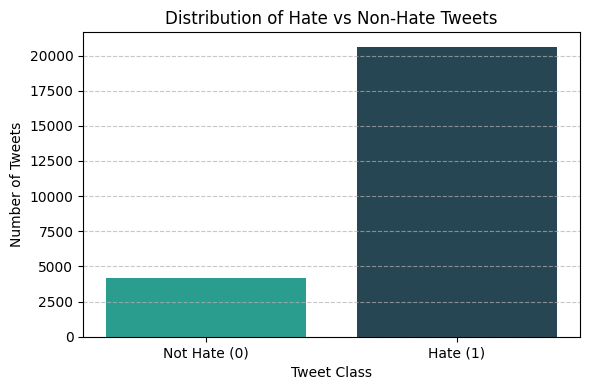

In [ ]:
# Histogram to understand comparative quantities of tweets annotated as hateful vs not hateful
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(['Not Hate (0)', 'Hate (1)'], label_counts, color=['#2a9d8f', '#264653'])
plt.title('Distribution of Hate vs Non-Hate Tweets')
plt.xlabel('Tweet Class')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Clearly this full dataset contains a significantly vaster quantity of hate speech than non hate speech, which may lead to a bias in having a better view of what is hate speech, while suffering from a lack of training as to what is not hate speech (perhaps more Type I and II errors will result).

## General Hate Speech Detector (Trained on Full Dataset)
### 5-Fold Cross-Validation Applied

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000) # Custom word vectorizer using Term-Frequency Inverse Document-Frequency
X_all = vectorizer.fit_transform(df['cleaned_text'])
y_all = df['label']

clf_general = LogisticRegression(max_iter=1000) # Well paired with lightweight word vectorizers for testing

Note that with 5 fold cross validation, all the data in the tweets set gets used for training and testing, in total, because each iteration picks a different partition of the data to be the test set, whereas the rest is the train set.  This ensures that the metrics are more robust and we can't just "get lucky" with a specific train-test split.

In [ ]:
# Perform detailed 5-fold cross-validation with multiple metrics
cv_results = cross_validate(clf_general, X_all, y_all, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], return_estimator=True)

y_pred_all = cross_val_predict(clf_general, X_all, y_all, cv=5)

# Clearly evaluate and visualize metrics
print("\n--- General Hate Speech Model - Detailed 5-Fold CV Metrics ---")
print(f"Accuracy:  {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Recall:    {cv_results['test_recall'].mean():.4f}")
print(f"F1-score:  {cv_results['test_f1'].mean():.4f}")


--- General Hate Speech Model - Detailed 5-Fold CV Metrics ---
Accuracy:  0.9359
Precision: 0.9449
Recall:    0.9802
F1-score:  0.9622


Overall these are good metrics and impressive results, however, note that they are inflated due to the bias of the dataset, which is comprised of a supermajority of hate speech, meaning that the training might be underfit as it is trained on so many instances of hate speech that even if it makes mistakes by classifying non-hate as hateful, the instances of this are few and far between due to the sparsity of non-hate tweets in the dataframe.

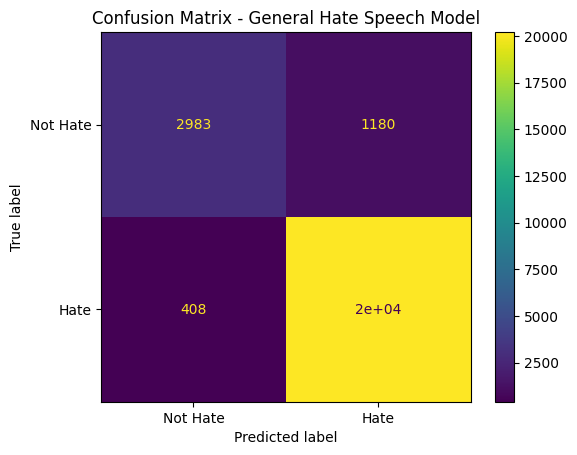

In [ ]:
# Confusion Matrix
cm_general = confusion_matrix(y_all, y_pred_all)
disp_general = ConfusionMatrixDisplay(confusion_matrix=cm_general, display_labels=['Not Hate', 'Hate'])
disp_general.plot()
plt.title("Confusion Matrix - General Hate Speech Model")
plt.show()

From the matrix we can see that when it comes to training hate speech on the full 24K tweets in the dataset (without specifically focusing on Anti-Arab language) the model performs very well, correctly identifying 20K cases of hate speech and 3K cases of non-hate speech, whereas only misclassifying around 400 true hate as non-hate, and 1K true non-hate as hate.  This supports the fact that inspite biases in the dataset, the model is effective.

In [ ]:
misclassified_general = df[y_all != y_pred_all].copy() # Compiling of false positive and false negatives
misclassified_general['predicted_label'] = y_pred_all[y_all != y_pred_all] # (ex. classified as 1 when in reality is 0, and vice versa)

print("\n--- Misclassified Examples (Edge Cases) ---")
print(misclassified_general[['cleaned_text', 'label', 'predicted_label']].head(10))


--- Misclassified Examples (Edge Cases) ---
                                          cleaned_text  label  predicted_label
0    ayasolovely woman shouldnt complain cleaning h...      0                1
40               momma said pussy cats inside doghouse      0                1
63   ddictedguys simplyaddictedtoguys woof woof hot...      0                1
70   rizonasfinest eggplant emoji doey say looked l...      0                1
119  dgarpixar overdosing heavy drugs doesnt sound ...      0                1
124  unnypicsdepot play soccer cheat girls wear kha...      0                1
140             ermosaalma isnt ghettoits smart im idc      0                1
149  reebo wants get nose bad bois scally chav sock...      0                1
158  eyshawnswag peel peel bring back rewind back i...      0                1
162  ingshawn hitethunduh thats get yellow flags am...      1                0


Note that 1 <=> hate speech; 0 <=> non hate speech.  It is critical to understand what sentiments trigger or escape the training of the model, for future improvements, or ensuring a more robust training set

In [ ]:
# Test model performance on custom examples
custom_examples = [
    "I hate this group of people so much!",
    "He will bake you a cake",
    "This is disgusting behavior from those people.",
    "Such a wonderful community event!"
]

In [ ]:
custom_X = vectorizer.transform(custom_examples)
custom_preds = clf_general.fit(X_all, y_all).predict(custom_X)

print("\n--- Custom Examples Classification ---")
for text, pred in zip(custom_examples, custom_preds):
    print(f"'{text}' ==> {'Hate' if pred else 'Not Hate'}")


--- Custom Examples Classification ---
'I hate this group of people so much!' ==> Hate
'He will bake you a cake' ==> Not Hate
'This is disgusting behavior from those people.' ==> Hate
'Such a wonderful community event!' ==> Hate


Evidence that even an extremely positive sentiment can be mistaken as hate speech, perhaps because the TF-IDF vectorizor has been overtrained on the association between strongly emotional expression and hatefulness--a likely source of bias from the Twitter (X) dataset.

## Custom Anti-Arab Sentiment Hate Speech Detector (Trained on Curated Set)
### 2-Fold Cross Validation Applied

In [ ]:
nlp = spacy.load("en_core_web_sm") # For named entity recognition (NER)

# A keywords list based on common keyword searches pertaining to Arabic culture / ethnicity
arab_or_muslim_keywords = [
    'arab', 'arabs', 'arabic', 'middle east', 'muslim', 'islam', 'mideast', 'gulf',
    'allah', 'mashallah', 'inshallah', 'ramadan', 'eid', 'halal', 'haram', 'ummah',
    'sunni', 'shia', 'mecca', 'medina', 'quran', 'hijab', 'burqa', 'jihad',
    'prophet', 'muhammad', 'imam', 'sheikh', 'salaam', 'masjid', 'caliph',
    'hijrah', 'zakat', 'fasting', 'iftar', 'suhur', 'taraweeh', 'niqab', 'abaya',
    'palestine'
]

This list of keywords is not exhaustive but is intended to be as explicit as possible, since it is not up to keywords to determine if text is referring to Arabs based on implicit wording--this task is delegated to NER, which means an area of improvement for this program would be a more robust method of identifying implicit references to Arabs, some of which may be veiled insults, figurative language, etc.

In [ ]:
def mentions_arabs_ner(text):
    doc = nlp(text)
    keywords = any(kw in text.lower() for kw in arab_or_muslim_keywords) # Explicit mention
    ner_mentions = any(ent.label_ in ['NORP', 'GPE', 'LOC'] and 'arab' in ent.text.lower() for ent in doc.ents) # Named entity related to Arab is found
    return keywords or ner_mentions # If either of these, Arabs are assumed to be mentioned

df['mentions_arabs'] = df['cleaned_text'].apply(mentions_arabs_ner)

Note that only a small number (225) out of over 24K of the tweets mention topics pertaining to Arab keywords.  This should still be enough to train on a broader dataset (for overall hate speech) and test against specifically on tweets pertaining to Arabs.

In [ ]:
arab_df = df[df['mentions_arabs']]
non_arab_df = df[~df['mentions_arabs']] # The complement of arab_df, containing only tweets that do not discuss Arabs.

# Verify counts clearly
print(f"Arab tweets available: {len(arab_df)}, Non-Arab tweets available: {len(non_arab_df)}")

Arab tweets available: 225, Non-Arab tweets available: 24558


In [ ]:
# Split Arab-related tweets 50-50
half_arab_count = len(arab_df) // 2
arab_train = arab_df.sample(n=half_arab_count, random_state=42)
arab_test = arab_df.drop(arab_train.index)

# Sample 20K non-Arab tweets for training (mix in with the training half of the Arab related tweets
non_arab_train = non_arab_df.sample(n=20000, random_state=42)

Note, althought the industry standard train-test split is 80-20, and not 50-50, we are training for hate speech, since we have a mechnanism of identifying tweets pertaining to Arabs already, and so we have a full dataset of 24K tweets to pull from in addition to the 50% of Arab-related tweets, which actually disproportionally outweight the amount of Arab-related tweets.

This will still yield better results hence why we merge the approx. 112 Arab-related tweets with 20000 other tweets from the dataset for training.

However, we test specifically on the effectiveness at identifying hateful sentiment amongst the Arab-related tweets (with the remaining unused Arab-related posts)--this is the mission of this project.

Note further that sampling is done randomly, although seeded to ensure reproducabiliy of the experiment's results.

In [ ]:
# Combine training data and vectorize
train_df = pd.concat([arab_train, non_arab_train]).sample(frac=1, random_state=42).reset_index(drop=True)
X_train = vectorizer.fit_transform(train_df['cleaned_text'])
y_train = train_df['label']

# Test data is the other half of Arab tweets
X_test = vectorizer.transform(arab_test['cleaned_text'])
y_test = arab_test['label']

In [ ]:
# Train model on this custom set
clf_arab_specific = LogisticRegression(max_iter=1000)
clf_arab_specific.fit(X_train, y_train)
y_pred = clf_arab_specific.predict(X_test)

# Evaluation metrics
print("\n--- Arab-specific Hate Speech Model Metrics (2-Fold) ---")
print(classification_report(y_test, y_pred))


--- Arab-specific Hate Speech Model Metrics (2-Fold) ---
              precision    recall  f1-score   support

           0       0.93      0.83      0.88        64
           1       0.80      0.92      0.86        49

    accuracy                           0.87       113
   macro avg       0.87      0.87      0.87       113
weighted avg       0.88      0.87      0.87       113



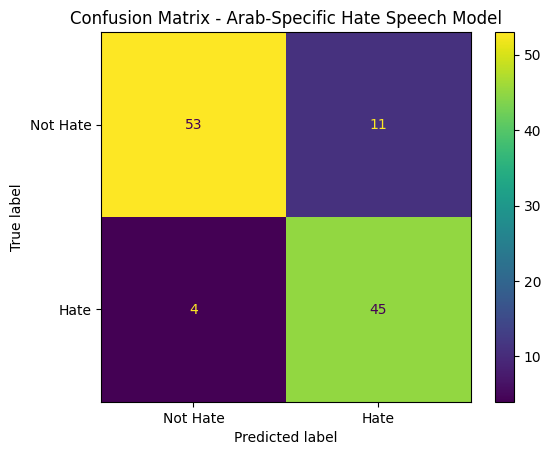

In [ ]:
# Confusion Matrix
cm_arab = confusion_matrix(y_test, y_pred)
disp_arab = ConfusionMatrixDisplay(confusion_matrix=cm_arab, display_labels=['Not Hate', 'Hate'])
disp_arab.plot()
plt.title("Confusion Matrix - Arab-Specific Hate Speech Model")
plt.show()

Evidently, this model performs slightly worse than the General Hate Speech model that was trained on the full dataset--specifically in regards to the proportion of false positives (believing that a consensus-determined non-hate comment was actually hate speech).  Perhaps this has to do with the training size or the specificity of Arab sentiments which differ too greatly from other types of hate speech that the system searches for.

However, overall this model still performs very well achieving 80's and 90's across the board of all evaluation metrics (recall, accuracy, precision, ...).  It would likely benefit from more test data and more diverse training data, but pleasanltly suprised on its ability to identify a high proportion of true Non-Hate comments, given that non-hate is scarce in the training dataset.

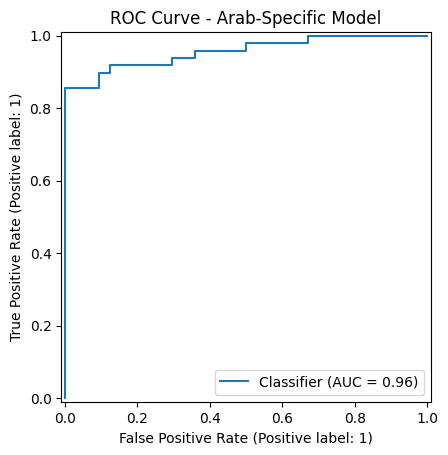

In [ ]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay
probs = clf_arab_specific.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, probs)
plt.title("ROC Curve - Arab-Specific Model")
plt.show()

The optimal shape for an ROC curve is 1. line from (0,0) to (0,1) and 2. line from (0,1) to (1,1).  This figure reaches very close (93% conformancy) to this shape with some bowing towards the top left corner area.

Note that the shape imples that from (0,0) to the end of the vertical line, no false positives, and then it curves slightly, meaning a few errors but nearly no false positives overall.  The flattening at the top and curving right indicates that the true positives are vastly captured by the test.

The indicates that the model is very well-tuned for specificity and sensitivity.

In [ ]:
misclassified_arab = arab_test.copy()
misclassified_arab['predicted_label'] = y_pred
errors = misclassified_arab[y_test != y_pred]

print("\n--- Misclassified Arab-related Examples ---")
print(errors[['cleaned_text', 'label', 'predicted_label']].head(10))


--- Misclassified Arab-related Examples ---
                                            cleaned_text  label  \
798    wearerepublicnotregime potus bo violated usa s...      0   
1240   lgrillo islamic state suspects indonesia chine...      0   
3333   berghattie nkscoyote wonder progs didnt relega...      0   
4694   hepnewsteam lmao dude said would get commitmen...      0   
7794   apaches mm rounds turn jihadis tomato soup ark...      1   
11471  idiotic censorship drive france president fail...      0   
12060  jihadi pop music debates yo bro hear latest ab...      0   
12065  jihadis running claim king saudi arabia died t...      0   
16164  emarquand jihadiinchief hussein urges restrain...      0   
17921  sabillofrights psychological warfare dhimmis d...      0   

       predicted_label  
798                  1  
1240                 1  
3333                 1  
4694                 1  
7794                 0  
11471                1  
12060                1  
12065            

In [ ]:
# Test on custom examples
custom_arab_examples = [
    "All Arabs are terrorists.",
    "Ramadan is a peaceful month for Muslims.",
    "Muslims are taking over the country!",
    "I had amazing falafel from a halal shop yesterday."
]

custom_X_arab = vectorizer.transform(custom_arab_examples)
custom_preds_arab = clf_arab_specific.predict(custom_X_arab)

In [ ]:
print("\n--- Custom Arab-related Examples Classification ---")
for text, pred in zip(custom_arab_examples, custom_preds_arab):
    print(f"'{text}' ==> {'Hate' if pred else 'Not Hate'}")


--- Custom Arab-related Examples Classification ---
'All Arabs are terrorists.' ==> Hate
'Ramadan is a peaceful month for Muslims.' ==> Hate
'Muslims are taking over the country!' ==> Hate
'I had amazing falafel from a halal shop yesterday.' ==> Not Hate


Once again this pattern of having overly positive sentiment "amazing falafel", "peaceful" for instance seems to be triggering the model's tendency to find false positives, which ought to be remedied, likely with better training.

This is evident in both the misclassified examples, enumerated in the cells above, as well as with the spot-check on custom sentence / post examples.

## Invoking BERT as a Word Encoder and Sentiment Vectorizer
### A Pre-Trained Model and Baseline to Compare Against

In [ ]:
# Load pre-trained BERT model for evaluation, this is CNERG's special model for English
bert_tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
bert_model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")

def bert_predict(text):
    # Tokenize the input text for the BERT model
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Disable gradient tracking for inference
    with torch.no_grad():
        logits = bert_model(**inputs).logits  # Get raw model outputs (logits)

    # Return predicted class (0 or 1) and the confidence score for that prediction
    return int(torch.argmax(logits)), torch.softmax(logits, dim=1).max().item()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
# Helper to evaluate a dataset
def evaluate_bert_on_dataset(dataset, label="Dataset"):
    y_true = dataset['label'].tolist()
    y_pred = [bert_predict(text)[0] for text in dataset['cleaned_text']]

    print(f"\n--- Pre-trained BERT Evaluation on {label} ---") # Automate the evaluation function results
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred) # Automate the confusion matrices
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Hate', 'Hate'])
    disp.plot()
    plt.title(f"Confusion Matrix - BERT on {label}")
    plt.show()

We test this BERT expertly calibrated model on 3 cases of data:
1. Non-Arab Tweets entirely (from a filtered dataframe)
2. Arab-Related Tweets entirely (from the other filtered dataframe)
3. A mix to ensure that performance of General Hate Speech is consistent whether it pertains to Arab sentiments being expressed or any other sentiment (that may or may not be hate speech)

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]


--- Pre-trained BERT Evaluation on Non-Arab Tweets ---
              precision    recall  f1-score   support

           0       0.48      0.90      0.63       305
           1       0.98      0.82      0.90      1695

    accuracy                           0.84      2000
   macro avg       0.73      0.86      0.76      2000
weighted avg       0.90      0.84      0.85      2000



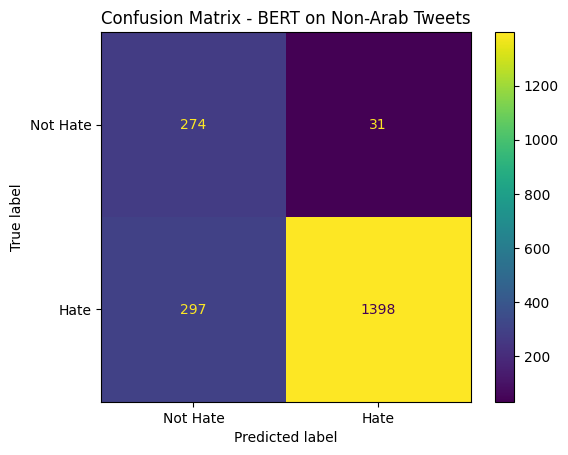

In [ ]:
# Case 1: Non-Arab tweets
non_arab_sample = non_arab_df.sample(n=2000, random_state=42) # A large but proportionally reasonable sample of the full dataset (given its size, 24K posts)
evaluate_bert_on_dataset(non_arab_sample, label="Non-Arab Tweets")

Overall CNERG's BERT performs mediocrely and slightly worse than our own custom trained Hate Speech Detector Model, indicating a competitive (slightly stronger) position for our own model.  It is clear that BERT has a tendency to have false negatives (being less strict than the annotators must have been about what is considered hate speech), given the greater quantity of (Non Hate, Hate) as opposed to (Non Hate, Non Hate) classifications.

This could be a bias on the part of the annotators / dataset to have a lower threshold for offense than the embedding and calibrating data that was fed to BERT.  This once again demonstrates a weakness in our models at identifying truly non-hateful speech given that the number of Type I and II errors rivel the number of non-hateful correctly-detected posts.  Alternatively, there are very few false positives (predicting a tweet as hateful when it wasn't).


--- Pre-trained BERT Evaluation on Arab Tweets ---
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       127
           1       0.84      0.83      0.84        98

    accuracy                           0.86       225
   macro avg       0.86      0.85      0.86       225
weighted avg       0.86      0.86      0.86       225



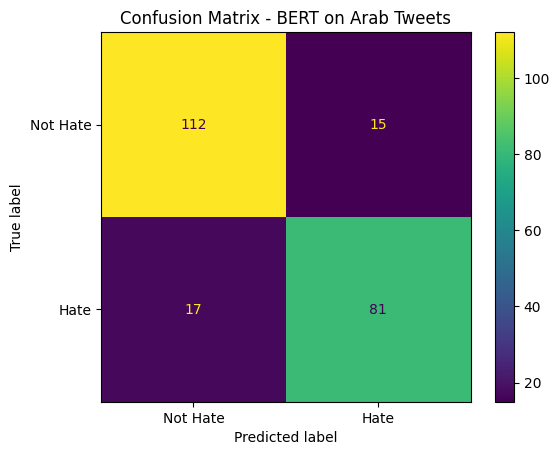

In [ ]:
# Case 2: Arab tweets
evaluate_bert_on_dataset(arab_df, label="Arab Tweets")

Here is where the effective performance shines across the board and a significant rivals the Custom Model's Arab sentiment classification tested priorly, with very few false positives and negatives (relative to the correctly classified tweets) and a surprisingly improved effectiveness at catching true non-hateful comments (specifically when it comes towards Arab-related commentary).  This indicates a notably accurate, precise, and performant model--very robust, which is its greatest strength compared to the Custom-trained (from scratch) Model tested above.


--- Pre-trained BERT Evaluation on Mixed Arab and Non-Arab Tweets ---
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        83
           1       0.93      0.87      0.90       141

    accuracy                           0.88       224
   macro avg       0.86      0.88      0.87       224
weighted avg       0.88      0.88      0.88       224



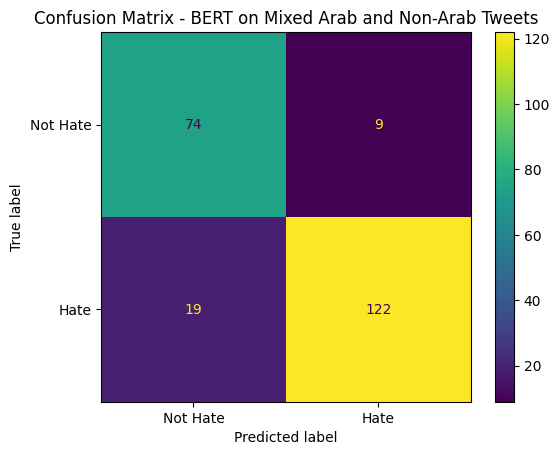

In [ ]:
# Case 3: Balanced Mix
mixed_sample = pd.concat([arab_df.sample(n=112, random_state=42), non_arab_df.sample(n=112, random_state=42)]).sample(frac=1, random_state=42)
evaluate_bert_on_dataset(mixed_sample, label="Mixed Arab and Non-Arab Tweets")

Once again there is consistent, and even slightly better performance across a mixed dataset, using the BERT model, nearly all metrics are in the high 80's and 90's making for a very effective overall hate speech classifier.

Ultimately, these 3 cases verify that the BERT model is considerably accurate and precise, it is well specified to general hate speech and anti-Arab hate speech alike, it doesn't have a strength for one over the other and so is clearly an optimal model choice to use in scaling up towards an industry-leading sentiment analysis product.

In [ ]:
# Custom mock tweet examples
mock_tweets = [
    "Arabs are ruining this country!",
    "Eid Mubarak to everyone celebrating!",
    "Muslims are terrorists, plain and simple.",
    "The Arabic language is beautiful.",
    "Why are there so many mosques now?",
    "I visited Mecca and it was life-changing."
]

Based on the results of this anecdotal evidence, and BERT's ability to not be tricked by sentiment that could induce false positive, it is clearly an effective model with high accuracy at identifying Anti-Arab hate speech sentiment, and would be useful if integrated for deployment as some chatbot tool, text checker, or monitoring system for a platform.

In [ ]:
print("\n--- BERT Predictions on Custom Mock Tweets ---")
for tweet in mock_tweets:
    label, score = bert_predict(tweet)
    print(f"'{tweet}' ==> {'Hate' if label else 'Not Hate'} (Confidence: {score:.2f})")


--- BERT Predictions on Custom Mock Tweets ---
'Arabs are ruining this country!' ==> Hate (Confidence: 0.73)
'Eid Mubarak to everyone celebrating!' ==> Not Hate (Confidence: 0.98)
'Muslims are terrorists, plain and simple.' ==> Not Hate (Confidence: 0.73)
'The Arabic language is beautiful.' ==> Not Hate (Confidence: 0.98)
'Why are there so many mosques now?' ==> Not Hate (Confidence: 0.97)
'I visited Mecca and it was life-changing.' ==> Not Hate (Confidence: 0.98)


## Deployment Demonstration
### A Lightweight Python Textbox Widget / App

This lightweight interactive cell serves as a proof of concept for model deployment. It allows users to input a sentence or tweet and returns an output based on two criteria: whether the text is related to Arabs or Muslims, and whether it is classified as hate speech by the pre-trained BERT model (which was proven to be statistically more effective than training on custom data). While not a full production system, this interface demonstrates how the model could be integrated into a moderation or content analysis workflow in a practical setting.

Potential use cases could be to limit or prevent hateful posts on social media platforms like the source platform (Twitter / X), as well as for personal use if someone wishes to be mindful / have a "second pair of eyes" warning them in case they are about to post or send a hateful message.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Chat logic and window
def analyze_input(text):
    arab_related = mentions_arabs_ner(text)
    is_hate, confidence = bert_predict(text)
    # Sentiment analysis logic portion:
    output = f"""
**User Input:** {text}

**Anti-Arab Hate Speech?:** {'🚨 Yes' if (is_hate and arab_related) else '✅ No'} (Confidence: {confidence:.2f})
"""
    display(Markdown(output))

# Chat-style visual details
input_box = widgets.Textarea(
    placeholder='Type a tweet or sentence here...',
    description='Input:',
    layout=widgets.Layout(width='100%', height='100px')
)

button = widgets.Button(description='Analyze')
output_area = widgets.Output()

def on_button_click(b):
    output_area.clear_output()
    with output_area:
        analyze_input(input_box.value)

button.on_click(on_button_click)

display(input_box, button, output_area)

Textarea(value='', description='Input:', layout=Layout(height='100px', width='100%'), placeholder='Type a twee…

Button(description='Analyze', style=ButtonStyle())

Output()

Expected output and example usage for the chatbox:

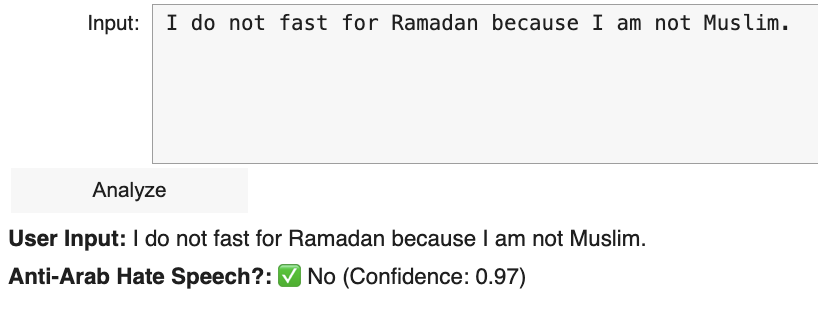